In [21]:
import multiresolutionimageinterface as mir
import openslide
import numpy as np
import skimage
import matplotlib.pyplot as plt

In [82]:
mr_image = reader.open('./51.tif')
level = 2
ds = mr_image.getLevelDownsample(level)

In [94]:
image_patch = mr_image.getUCharPatch(int(2568 * ds), int(5732 * ds), 1300, 1200, level)

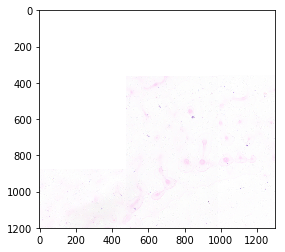

In [95]:
plt.imshow(image_patch)

In [4]:
reader = mir.MultiResolutionImageReader()
slide = openslide.OpenSlide('./51.tif')

In [99]:
208796 / slide.level_dimensions[7][1] * abs(minr- maxr)

23171.10729613734

In [8]:
slide.level_dimensions

((89262, 208796),
 (44631, 104398),
 (22315, 52199),
 (11157, 26099),
 (5578, 13049),
 (2789, 6524),
 (1394, 3262),
 (697, 1631),
 (348, 815))

In [13]:
thumb = slide.get_thumbnail(slide.level_dimensions[7])


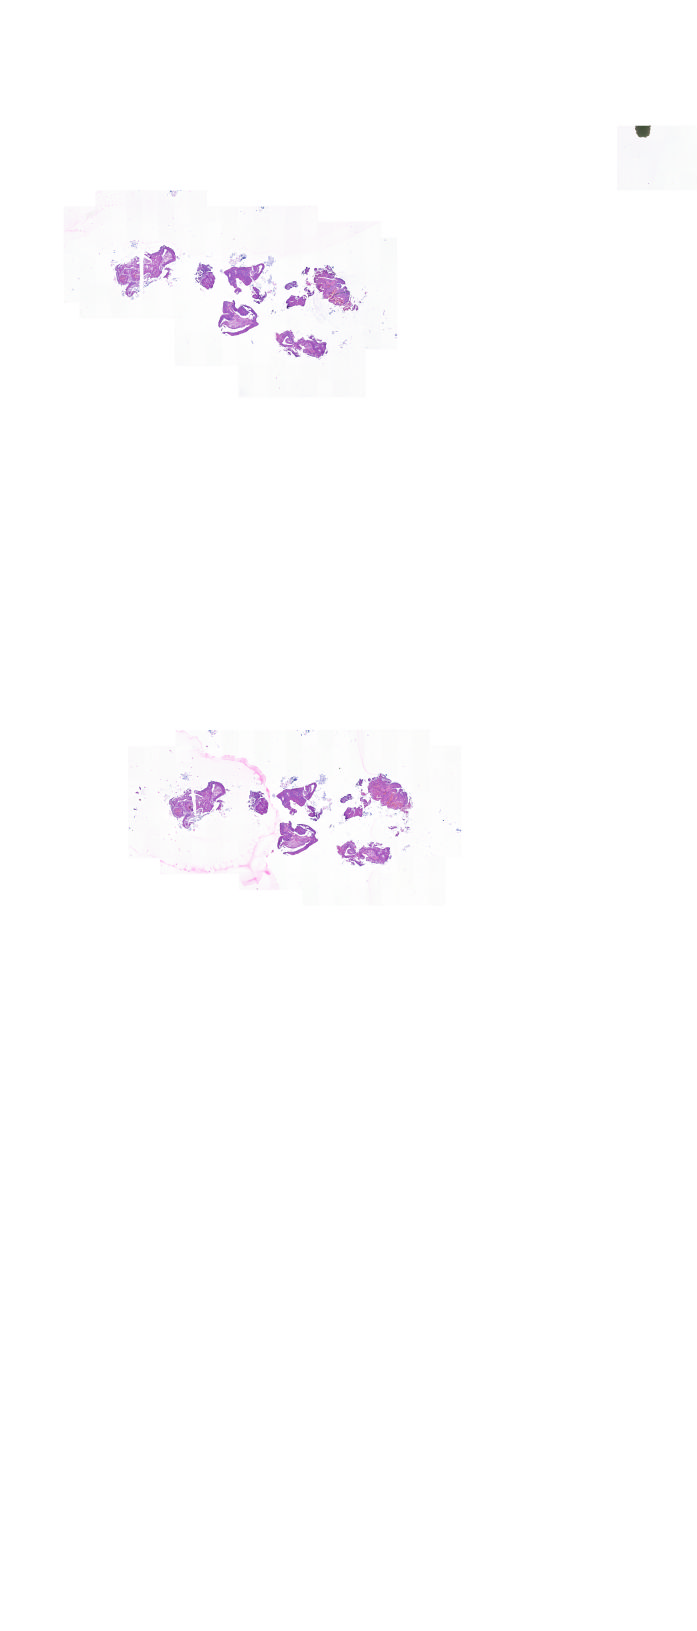

In [14]:
thumb

In [22]:
thumb_gray = skimage.color.rgb2gray(np.array(thumb))

In [238]:
coins = 1. - thumb_gray

In [239]:
np.unique(coins)

array([0.00000000e+00, 2.82745098e-04, 5.65490196e-04, ...,
       8.07289412e-01, 8.07825098e-01, 8.22172941e-01])

Text(0.5, 1.0, 'histogram of grey values')

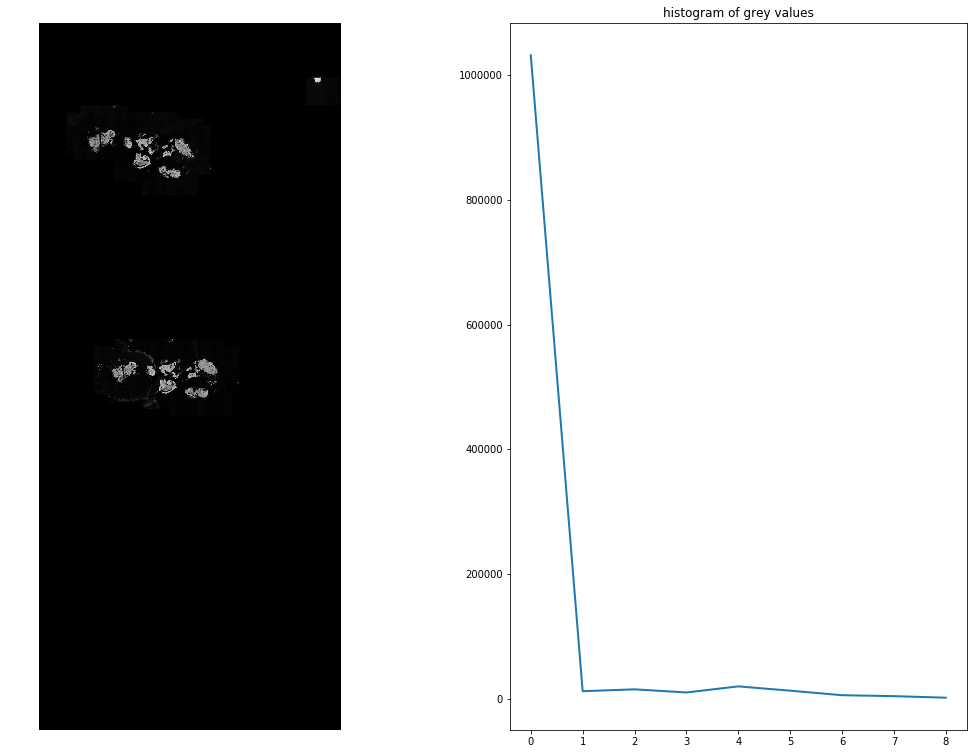

In [249]:
hist = np.histogram(coins * 255., bins=np.arange(0, 10))

plt.figure(figsize=(18, 13))
plt.subplot(121)
plt.imshow(coins, cmap=plt.cm.gray, interpolation='nearest')
plt.axis('off')
plt.subplot(122)
plt.plot(hist[1][:-1], hist[0], lw=2)
plt.title('histogram of grey values')

Text(0.5, 1.0, 'elevation_map')

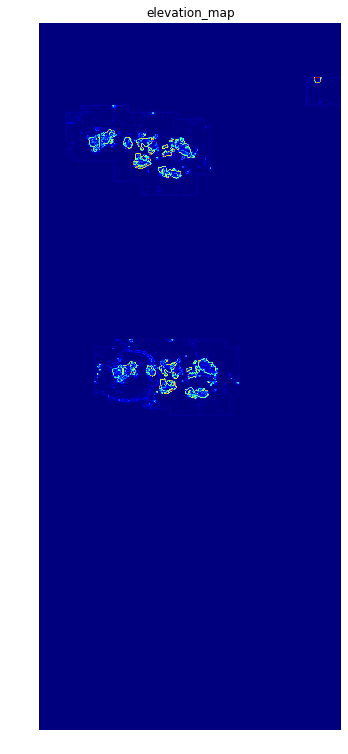

In [248]:
from skimage.filters import sobel

elevation_map = sobel(coins)

plt.figure(figsize=(14, 13))
plt.imshow(elevation_map, cmap=plt.cm.jet, interpolation='nearest')
plt.axis('off')
plt.title('elevation_map')

Text(0.5, 1.0, 'markers')

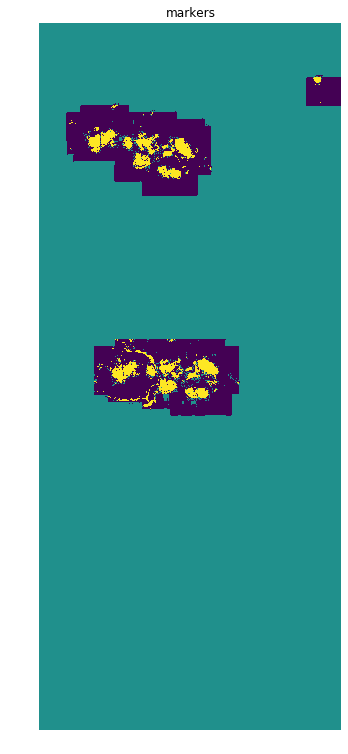

In [269]:
markers = np.zeros_like(coins)
markers[coins <= 1/255.] = 1
markers[coins >= 15/255.] = 2

plt.figure(figsize=(14, 13))
plt.imshow(markers, interpolation='nearest')
plt.axis('off')
plt.title('markers')

Text(0.5, 1.0, 'segmentation')

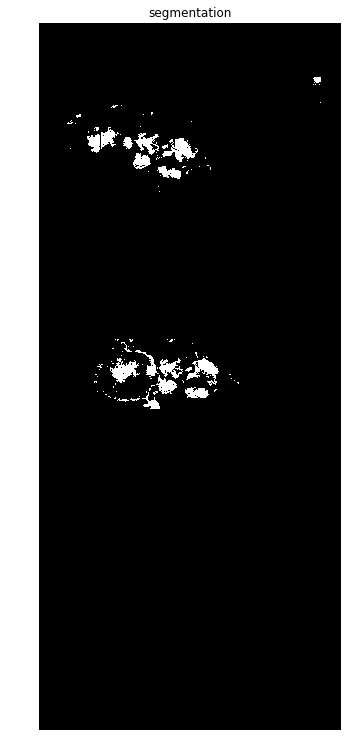

In [278]:
from skimage.morphology import watershed
segmentation = watershed(elevation_map, markers)
segmentation = morphology.remove_small_objects(segmentation)
plt.figure(figsize=(14, 13))
plt.imshow(segmentation, cmap=plt.cm.gray, interpolation='nearest')
plt.axis('off')
plt.title('segmentation')

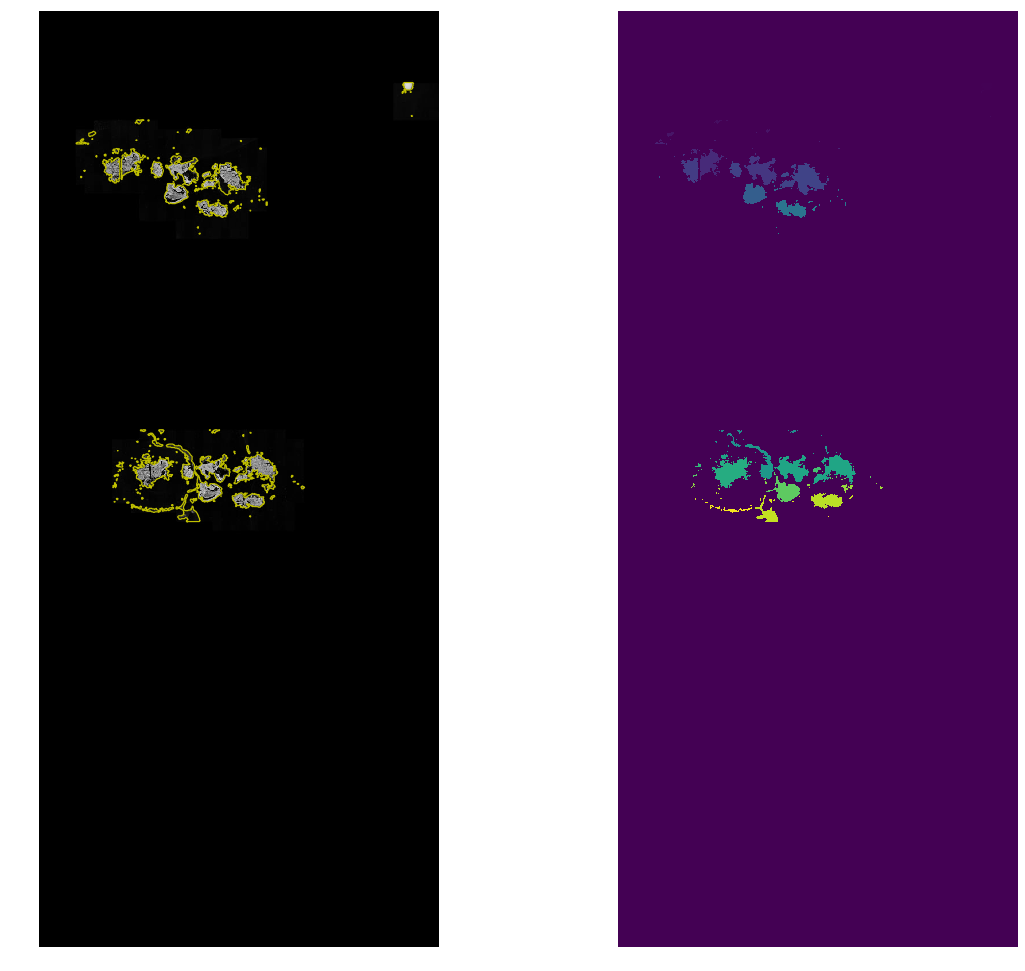

In [279]:
from scipy import ndimage
segmentation = ndimage.binary_fill_holes(segmentation - 1)
labeled_coins, _ = ndimage.label(segmentation)

plt.figure(figsize=(16, 13))
plt.subplot(121)
plt.imshow(coins, cmap=plt.cm.gray, interpolation='nearest')
plt.contour(segmentation, [0.5], linewidths=1.2, colors='y')
plt.axis('off')
plt.subplot(122)
plt.imshow(labeled_coins, interpolation='nearest')
plt.axis('off')
margins = dict(hspace=0.01, wspace=0.01, top=1, bottom=0, left=0, right=1)
plt.subplots_adjust(**margins)

In [127]:
def imshow(img):
    fig = plt.figure(figsize=img.shape)
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(img)

In [122]:
fill_coins.shape

(1631, 697)

In [129]:
markers = np.zeros_like(thumb_gray)
markers[thumb_gray < 30/250.] = 1
markers[thumb_gray > 150/250.] = 2

In [130]:
from skimage.filters import sobel
elevation_map = sobel(thumb_gray)

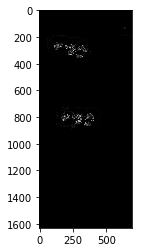

In [132]:
plt.imshow(elevation_map, cmap=plt.cm.gray)

In [222]:
markers = np.zeros_like(thumb_gray)
markers[thumb_gray < 30/250] = 1
markers[thumb_gray > 150/250] = 2
from skimage.morphology import watershed
segmentation = watershed(thumb_gray, markers)

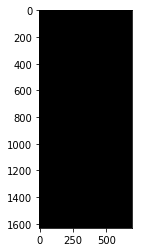

In [223]:
plt.imshow(segmentation, cmap=plt.cm.gray)

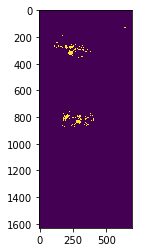

In [121]:
plt.imshow(fill_coins.astype('uint8'), )

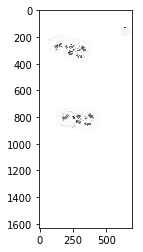

In [26]:
plt.imshow(thumb_gray, cmap=plt.cm.gray)

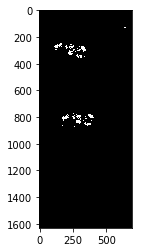

In [110]:
plt.imshow(thumb_gray < 0.8, cmap=plt.cm.gray)

In [30]:
mask = thumb_gray != 1

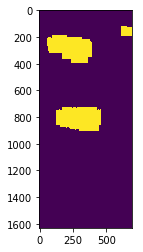

In [57]:
plt.imshow(mask)

In [38]:
from skimage import morphology, measure

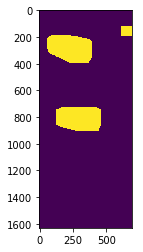

In [72]:
convx = morphology.convex_hull_object(mask)
plt.imshow(convx)

In [73]:
mask = morphology.remove_small_holes(convx)
mask = morphology.remove_small_objects(mask)

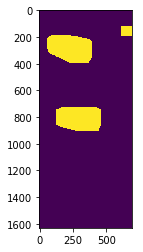

In [74]:
plt.imshow(convx.astype('uint8'))

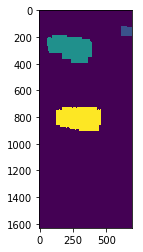

In [75]:
plt.imshow(label_img)

In [76]:
np.unique(label_img)

array([0, 1, 2, 3, 4])

In [77]:
label_image = measure.label(mask)
for each in measure.regionprops(label_img):
    print(each.bbox)

(120, 616, 192, 697)
(184, 62, 400, 400)
(328, 169, 360, 172)
(728, 128, 909, 464)


In [78]:
import matplotlib.patches as mpatches

In [79]:
image_label_overlay = skimage.color.label2rgb(label_image, image=mask)

In [96]:
minr, maxr

(728, 909)

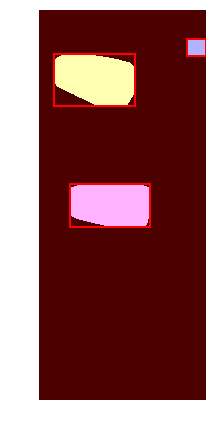

In [80]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

for region in measure.regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 1:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()